---
title: SSB Contrast Transfer
authors: [Julie Marie Bekkevold, Georgios Varnavides]
date: 2024-09-30
---

In [1]:
# enable interactive matplotlib
# %matplotlib widget 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import ctf # import custom plotting / utils

import ipywidgets
from IPython.display import display

## 4D STEM Simulation

In [91]:
# parameters
n = 64
q_max = 2 # inverse Angstroms
q_probe = 1 # inverse Angstroms
wavelength = 0.019687 # 300kV
defocus = 16
sampling = 1 / q_max / 2 # Angstroms
reciprocal_sampling = 2 * q_max / n # inverse Angstroms

scan_step_size = 1 # pixels
sx = sy = n//scan_step_size
phi0 = 1.0

### White Noise Potential

In [92]:
def white_noise_object_2D(n, phi0):
    """ creates a 2D real-valued array, whose FFT has random phase and constant amplitude """

    evenQ = n%2 == 0
    
    # indices
    pos_ind = np.arange(1,(n if evenQ else n+1)//2)
    neg_ind = np.flip(np.arange(n//2+1,n))

    # random phase
    arr = np.random.randn(n,n)
    
    # top-left // bottom-right
    arr[pos_ind[:,None],pos_ind[None,:]] = -arr[neg_ind[:,None],neg_ind[None,:]]
    # bottom-left // top-right
    arr[pos_ind[:,None],neg_ind[None,:]] = -arr[neg_ind[:,None],pos_ind[None,:]]
    # kx=0
    arr[0,pos_ind] = -arr[0,neg_ind]
    # ky=0
    arr[pos_ind,0] = -arr[neg_ind,0]

    # zero-out components which don't have k-> -k mapping
    if evenQ:
        arr[n//2,:] = 0 # zero highest spatial freq
        arr[:,n//2] = 0 # zero highest spatial freq

    arr[0,0] = 0 # DC component

    # fourier-array
    arr = np.exp(2j*np.pi*arr)*phi0

    # inverse FFT and remove floating point errors
    arr = np.fft.ifft2(arr).real
    
    return arr

# potential
potential = white_noise_object_2D(n,phi0)
complex_obj = np.exp(1j*potential)

### Probe

In [93]:
# we build probe in Fourier space, using a soft aperture

qx = qy = np.fft.fftfreq(n,sampling)
q = np.sqrt(qx[:,None]**2 + qy[None,:]**2)

def soft_aperture(q,q_probe,reciprocal_sampling):
    return np.sqrt(
        np.clip(
            (q_probe - q)/reciprocal_sampling + 0.5,
            0,
            1,
        ),
    )

def hard_aperture(q,q_probe,reciprocal_sampling):
    return ((q_probe - q)>0).astype(np.float64)

probe_array_fourier = hard_aperture(q,q_probe,reciprocal_sampling) * np.exp(-1j*np.pi*wavelength*defocus*q**2)

# normalized s.t. np.sum(np.abs(probe_array_fourier)**2) = 1.0
probe_array_fourier /= np.sqrt(np.sum(np.abs(probe_array_fourier)**2))

# we then take the inverse FFT, and normalize s.t. np.sum(np.abs(probe_array)**2) = 1.0
probe_array = np.fft.ifft2(probe_array_fourier) * n

In [94]:
x = y = np.arange(0.,n,scan_step_size)
xx, yy = np.meshgrid(x,y,indexing='ij')
positions = np.stack((xx.ravel(),yy.ravel()),axis=-1)
row, col = ctf.return_patch_indices(positions,(n,n),(n,n))

intensities = ctf.simulate_data(
    complex_obj,
    probe_array,
    row,
    col,
).reshape((sx,sy,n,n))**2 / n**2

intensities_FFT = np.fft.fft2(intensities,axes=(0,1))

In [95]:
def annular_segmented_detectors(
    gpts,
    sampling,
    n_angular_bins,
    rotation_offset = 0,
    inner_radius = 0,
    outer_radius = np.inf,
):
    """ """
    nx,ny = gpts
    sx,sy = sampling

    k_x = np.fft.fftfreq(nx,sx)
    k_y = np.fft.fftfreq(ny,sy)

    k = np.sqrt(k_x[:,None]**2 + k_y[None,:]**2)
    radial_mask = ((inner_radius <= k) & (k < outer_radius))
    
    theta = (np.arctan2(k_y[None,:], k_x[:,None]) + rotation_offset) % (2 * np.pi)
    angular_bins = np.floor(n_angular_bins * (theta / (2 * np.pi))) + 1
    angular_bins *= radial_mask.astype("int")

    angular_bins = [np.fft.fftshift((angular_bins == i).astype("int")) for i in range(1,n_angular_bins+1)]
    
    return angular_bins


def array_detectors(
    gpts,
    sampling,
    n_elements,
    rectangular_cuttoff_scattering_angles,
    verbose=False,
):
    """ """
    nx, ny = gpts
    sx, sy = sampling

    k_x = np.fft.fftshift(np.fft.fftfreq(nx, sx))
    k_y = np.fft.fftshift(np.fft.fftfreq(ny, sy))

    dx, dy = n_elements
    rx, ry = rectangular_cuttoff_scattering_angles
    idx = (np.round((np.abs(k_x + rx)).argmin() / dx) * dx).astype("int")
    idy = (np.round((np.abs(k_y + ry)).argmin() / dy) * dy).astype("int")

    super_k_x = np.arange(nx)[idx:-idx or None].reshape(dx, -1)
    super_k_y = np.arange(ny)[idy:-idy or None].reshape(dy, -1)

    if verbose:
        print(
            f"""Target cutoff angles: ({rx:.1f},{ry:.1f})
    Final cutoff angles:  ({-k_x[idx]:.1f},{-k_y[idy]:.1f})"""
        )

    masks = []

    for kx in super_k_x:
        for ky in super_k_y:
            mask = np.zeros(gpts, dtype="int")
            mask[kx[:, None], ky[None, :]] = 1
            masks.append(mask)

    return masks

def mask_intensities_using_virtual_detectors(
    corner_centered_intensities,
    center_centered_masks,
): 
    """ """
    
    masks = np.fft.ifftshift(np.asarray(center_centered_masks).astype(np.bool_),axes=(-1,-2))
    inverse_mask = (1-masks.sum(0)).astype(np.bool_)
    
    intensities = np.asarray(corner_centered_intensities.copy())

    for mask in masks:
        val = np.sum(corner_centered_intensities * mask,axis=(-1,-2)) / np.sum(mask)
        intensities[:,:,mask] = val[:,:,None]
    intensities[:,:,inverse_mask] = 0.0 

    return intensities

In [104]:
# virtual_masks_annular = annular_segmented_detectors(
#     gpts=(n,n),
#     sampling=(sampling,sampling),
#     n_angular_bins=8,
#     inner_radius=0,
#     outer_radius=q_probe,
#     rotation_offset=0,
# ) 

# virtual_masks_annular = array_detectors(
#     (n,n),
#     (sampling,sampling),
#     (8,8),
#     (q_max,q_max),
# )

# masked_intensities = mask_intensities_using_virtual_detectors(
#     intensities,
#     virtual_masks_annular
# )

# masked_intensities_FFT = np.fft.fft2(masked_intensities,axes=(0,1))

In [96]:
# shifted complex probes
# gamma = np.empty_like(intensities,dtype=complex_obj.dtype)
psi = np.empty_like(complex_obj)
# analytical_ctf = np.empty_like(complex_obj,dtype=np.float64)
sx, sy = psi.shape

Kx = qx
Ky = qy

Qx = qx
Qy = qy

K = np.sqrt(Kx[:,None]**2 + Ky[None,:]**2)
A_q = hard_aperture(K,q_probe,reciprocal_sampling) * np.exp(-1j*np.pi*wavelength*defocus*K**2)
A_q_conj = A_q.conj()
A_q_sum = np.abs(A_q).sum()

for ind_x in range(sx):
    for ind_y in range(sy):
        # G = masked_intensities_FFT[ind_x,ind_y]
        G = intensities_FFT[ind_x,ind_y]
        if ind_x == 0 and ind_y == 0 :
            psi[ind_x,ind_y] = np.abs(G).sum()
            # analytical_ctf[ind_x,ind_y] = 0.0
        else:
            q_plus_Q = np.sqrt((Kx[:,None]+Qx[ind_x])**2 + (Ky[None,:]+Qy[ind_y])**2)
            A_q_plus_Q = hard_aperture(q_plus_Q,q_probe,reciprocal_sampling) * np.exp(-1j*np.pi*wavelength*defocus*q_plus_Q**2)
    
            q_minus_Q = np.sqrt((Kx[:,None]-Qx[ind_x])**2 + (Ky[None,:]-Qy[ind_y])**2)
            A_q_minus_Q = hard_aperture(q_minus_Q,q_probe,reciprocal_sampling) * np.exp(-1j*np.pi*wavelength*defocus*q_minus_Q**2)

            # gamma[ind_x,ind_y] = A_q_conj * A_q_minus_Q - A_q * A_q_plus_Q.conj()
            gamma = A_q_conj * A_q_minus_Q - A_q * A_q_plus_Q.conj()
            gamma_abs = np.abs(gamma)
            gamma_ind = gamma_abs > 0
            psi[ind_x,ind_y] = (G[gamma_ind] *  np.conj(gamma[gamma_ind])/gamma_abs[gamma_ind]).sum()
            # analytical_ctf[ind_x,ind_y] = gamma_abs[gamma_ind].sum() / A_q_sum

recon = np.fft.ifft2(psi)
numeric_ctf = np.abs(np.fft.fft2(np.angle(recon)))
numeric_ctf[0,0] = 0.0

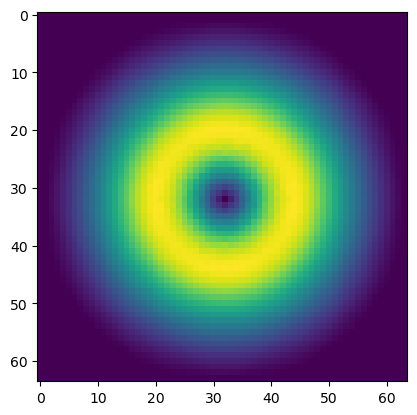

In [108]:
plt.imshow(np.fft.fftshift(numeric_ctf))

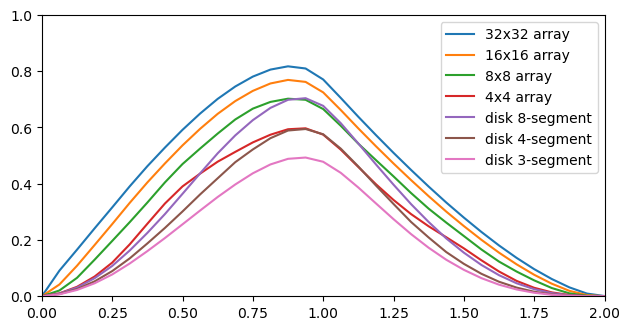

In [105]:
fig,ax = plt.subplots()

ax.plot(q_bins_32,I_bins_32,label='32x32 array')
ax.plot(q_bins_16,I_bins_16,label='16x16 array')
ax.plot(q_bins_8,I_bins_8,label='8x8 array')
ax.plot(q_bins_4,I_bins_4,label='4x4 array')
ax.plot(q_bins_disk_8,I_bins_disk_8,label='disk 8-segment')
ax.plot(q_bins_disk_4,I_bins_disk_4,label='disk 4-segment')
ax.plot(q_bins_disk_3,I_bins_disk_3,label='disk 3-segment')
ax.set_xlim([0,2])
ax.set_ylim([0,1])
ax.set_aspect("equal")
ax.legend()

fig.tight_layout()

In [106]:
fig.savefig("segmented-detector SSB.png",bbox_inches='tight')

In [60]:
### Vectorized
# # shifted complex probes
# Kx = qx
# Ky = qy

# K = np.sqrt(Kx[None,None,:,None]**2 + Ky[None,None,None,:]**2)
# A_q = hard_aperture(K,q_probe,reciprocal_sampling) * np.exp(-1j*np.pi*wavelength*defocus*K**2)

# Qx = qx
# Qy = qy
# q_plus_Qx = (Kx[None,None,:,None] + Qx[:,None,None,None])
# q_plus_Qy = (Ky[None,None,None,:] + Qy[None,:,None,None])
# q_plus_Q = np.sqrt(q_plus_Qx**2 + q_plus_Qy**2)
# A_q_plus_Q = hard_aperture(q_plus_Q,q_probe,reciprocal_sampling) * np.exp(-1j*np.pi*wavelength*defocus*q_plus_Q**2)

# q_minus_Qx = (Kx[None,None,:,None] - Qx[:,None,None,None])
# q_minus_Qy = (Ky[None,None,None,:] - Qy[None,:,None,None])
# q_minus_Q = np.sqrt(q_minus_Qx**2 + q_minus_Qy**2)
# A_q_minus_Q = hard_aperture(q_minus_Q,q_probe,reciprocal_sampling) * np.exp(-1j*np.pi*wavelength*defocus*q_minus_Q**2)

# # complex probes overlap
# gamma = (A_q.conj() * A_q_minus_Q) - (A_q * A_q_plus_Q.conj())

# gamma_inds = np.where(np.abs(gamma) > 0)
# raveled_inds = np.ravel_multi_index(gamma_inds,gamma.shape)
# weights = intensities_FFT[gamma_inds] * gamma[gamma_inds].conj()

# # summation
# psi = np.empty_like(complex_obj)
# psi.real = np.bincount(
#     raveled_inds,
#     weights.real,
#     minlength=gamma.size
# ).reshape(
#     gamma.shape
# ).sum(
#     (-1,-2)
# )

# psi.imag = np.bincount(
#     raveled_inds,
#     weights.imag,
#     minlength=gamma.size
# ).reshape(
#     gamma.shape
# ).sum(
#     (-1,-2)
# )

# psi[0,0] = np.abs(intensities_FFT[0,0]).sum()
# recon = np.fft.ifft2(psi)